# Timestamp

In [1]:
# Imports
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tqdm
tqdm.pandas(desc="Progress")

In [2]:
# Metadata
header_rows = 3
input_file = "DATA_2.CSV"
output_file = "INFLUX_" + input_file

In [3]:
df = pd.read_csv(input_file, header=header_rows, engine='pyarrow')


In [4]:
df["_time"] = pd.to_datetime(df["_time"], unit="ms")

In [5]:
data = df[["_time", "_field", "_value"]].set_index(["_time","_field"]).unstack().droplevel(0, axis=1)

# Calibration

In [32]:
temp_df = data[["Temperature", "DHT temp"]].rename({"Temperature": "sense", "DHT temp": "dht"}, axis=1)
hum_df = data[["Humidity", "DHT hum"]].rename({"Humidity": "sense", "DHT hum": "dht"}, axis=1)

## Temperature

In [57]:
group_temp_df = temp_df.groupby("dht").describe().droplevel(0,axis=1)
group_temp_df

,count,mean,std,min,25%,50%,75%,max
dht,,,,,,,,
26.0,98.0,31.869490,0.041626,31.76,31.83,31.87,31.91,31.96
26.1,15371.0,31.867103,0.049461,31.70,31.83,31.87,31.91,32.06
26.2,8993.0,31.935572,0.041114,31.72,31.91,31.95,31.96,32.08
26.3,10042.0,31.995614,0.049534,31.83,31.96,32.00,32.04,32.21
26.4,3906.0,32.122721,0.044735,31.95,32.09,32.13,32.15,32.30
26.5,3472.0,32.209948,0.042493,32.06,32.19,32.21,32.24,32.35
26.6,3404.0,32.297306,0.051655,32.11,32.26,32.30,32.34,32.48
26.7,3143.0,32.381324,0.039136,32.22,32.35,32.39,32.41,32.50
26.8,4053.0,32.485650,0.065134,32.28,32.45,32.48,32.54,32.67


### Polyfit

Polyfit: 
0.8384 x - 0.5046

Covariance matrix:
[[ 7.38398406e-06 -2.37025596e-04]
 [-2.37025596e-04  7.60910244e-03]]



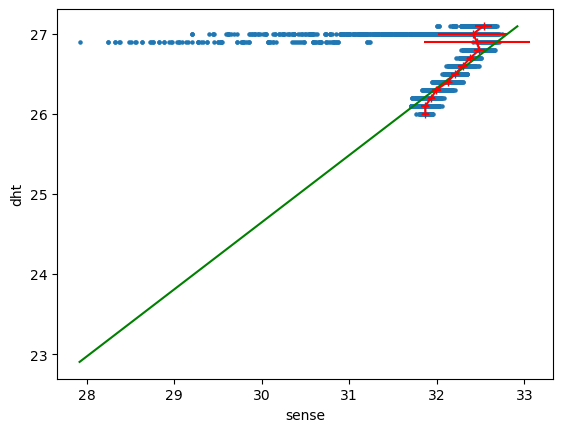

In [65]:
p_temp, cov_temp = np.polyfit(temp_df["sense"], temp_df["dht"], deg=1, cov=True)
poly_temp = np.poly1d(p_temp)

print(f"Polyfit:{poly_temp}\n")
print(f"Covariance matrix:\n{cov_temp}\n")

ax = temp_df.plot.scatter(x="sense", y="dht", marker=".")
ax.errorbar(group_temp_df["mean"], group_temp_df.index, xerr=group_temp_df["std"], c="r", marker="+")

x_temp = np.arange(temp_df["sense"].min(), temp_df["sense"].max() + 0.5, 0.5)
ax.plot(x_temp, poly_temp(x_temp), c="g")

plt.show()

### Error

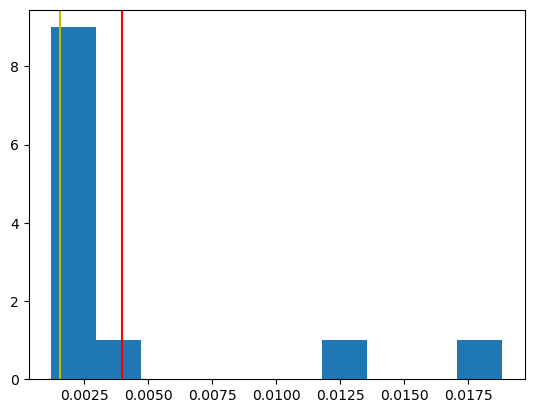

Median: 0.001550131137004188
Mean: 0.0039600293810003575


In [69]:
temp_error = (group_temp_df["std"] / group_temp_df["mean"])

plt.hist(temp_error)
plt.axvline(temp_error.mean(), c="r")
plt.axvline(temp_error.median(), c="y")
plt.show()

print(f"Median: {temp_error.median()}")
print(f"Mean: {temp_error.mean()}")

## Humidity

In [70]:
group_hum_df = hum_df.groupby("dht").describe().droplevel(0,axis=1)
group_hum_df

,count,mean,std,min,25%,50%,75%,max
dht,,,,,,,,
35.1,7.0,33.871429,0.050143,33.79,33.8500,33.890,33.9000,33.92
35.2,1712.0,33.881782,0.094506,33.55,33.8175,33.890,33.9500,34.16
35.3,2276.0,33.939332,0.092883,33.65,33.8700,33.940,34.0000,34.26
35.4,4785.0,34.032621,0.109154,33.62,33.9600,34.040,34.1100,34.36
35.5,3608.0,34.118742,0.109155,33.74,34.0400,34.110,34.1900,34.48
35.6,3590.0,34.328437,0.127768,33.82,34.2500,34.340,34.4200,34.67
35.7,5883.0,34.439658,0.111915,34.03,34.3700,34.450,34.5200,34.81
35.8,11209.0,34.513691,0.100669,34.05,34.4500,34.520,34.5800,34.84
35.9,8491.0,34.581809,0.101570,34.22,34.5200,34.580,34.6400,35.08


### Polyfit

Polyfit: 
0.6958 x + 11.83

Covariance matrix:
[[ 1.36531772e-06 -4.73645146e-05]
 [-4.73645146e-05  1.64407195e-03]]



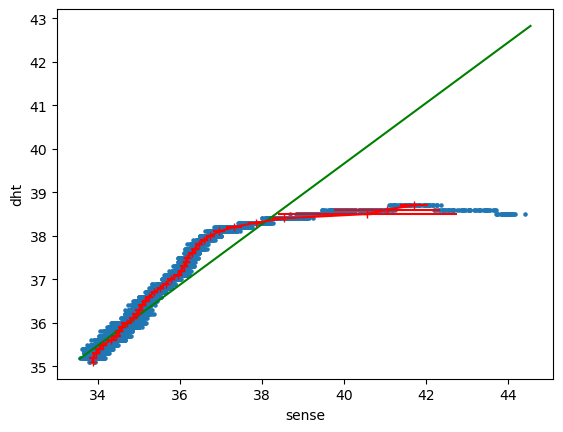

In [73]:
p_hum, cov_hum = np.polyfit(hum_df["sense"], hum_df["dht"], deg=1, cov=True)
poly_hum = np.poly1d(p_hum)

print(f"Polyfit:{poly_hum}\n")
print(f"Covariance matrix:\n{cov_hum}\n")

ax = hum_df.plot.scatter(x="sense", y="dht", marker=".")
ax.errorbar(group_hum_df["mean"], group_hum_df.index, xerr=group_hum_df["std"], c="r", marker="+")

x_hum = np.arange(hum_df["sense"].min(), hum_df["sense"].max() + 0.5, 0.5)
ax.plot(x_hum, poly_hum(x_hum), c="g")

plt.show()

### Error

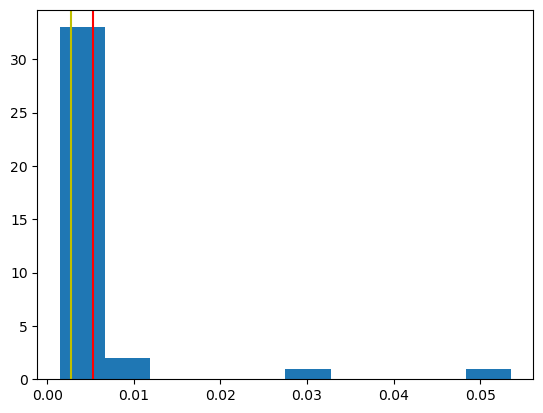

0.0027892928475895342
0.0053063136094630165


In [12]:
hum_error = (group_hum_df["std"] / group_hum_df["mean"])

plt.hist(hum_error)
plt.axvline(hum_error.mean(), c="r")
plt.axvline(hum_error.median(), c="y")
plt.show()

print(f"Median: {hum_error.median()}")
print(f"Mean: {hum_error.mean()}")